[View in Colaboratory](https://colab.research.google.com/github/shreyas-kalmegh/time-series-AV/blob/master/timeSeriesProphet.ipynb)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = (15, 8)

/usr/local/lib/python3.6/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Problem Statement

Congratulations on your new job! This time you are helping out Unicorn Investors with your data hacking skills. They are considering making an investment in a new form of transportation - JetRail. JetRail uses Jet propulsion technology to run rails and move people at a high speed! While JetRail has mastered the technology and they hold the patent for their product, the investment would only make sense, if they can get more than 1 Million monthly users with in next 18 months.

You need to help Unicorn ventures with the decision. They usually invest in B2C start-ups less than 4 years old looking for pre-series A funding. In order to help Unicorn Ventures in their decision, you need to forecast the traffic on JetRail for the next 7 months. You are provided with traffic data of JetRail since inception in the test file.

Evaluation Metric:

Root Mean Squre Error (RMSE) is the evaluation metric for this contest

Note: Public and private split is 20:80 where first 44 days in public and next 169 days in private

## Hypothesis


 *   There might be an inreasing trend over time
 * Traffic may be high in holiday season i.e May to October
 * Traffic during weekdays may be higher than weekends
 * Traffic may be high during peak hours


## Load the dataset

In [2]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving test.csv to test (3).csv
Saving train.csv to train (3).csv
User uploaded file "test.csv" with length 122701 bytes
User uploaded file "train.csv" with length 489054 bytes


In [3]:
import io
train = pd.read_csv(io.StringIO(uploaded['train.csv'].decode('utf-8')))
test = pd.read_csv(io.StringIO(uploaded['test.csv'].decode('utf-8')))

train.head()

,ID,Datetime,Count
0,0,25-08-2012 00:00,8
1,1,25-08-2012 01:00,2
2,2,25-08-2012 02:00,6
3,3,25-08-2012 03:00,2
4,4,25-08-2012 04:00,2


In [88]:
test.head()


,ID,Datetime
0,18288,26-09-2014 00:00
1,18289,26-09-2014 01:00
2,18290,26-09-2014 02:00
3,18291,26-09-2014 03:00
4,18292,26-09-2014 04:00


In [4]:
Datetimetrain = pd.to_datetime(train.Datetime, format='%d-%m-%Y %H:%M')
train.Datetime = Datetimetrain
train.set_index('Datetime', inplace=True)

Datetimetest = pd.to_datetime(test.Datetime, format='%d-%m-%Y %H:%M')
test.Datetime = Datetimetest
test.set_index('Datetime', inplace=True)

train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 18288 entries, 2012-08-25 00:00:00 to 2014-09-25 23:00:00
Data columns (total 2 columns):
ID       18288 non-null int64
Count    18288 non-null int64
dtypes: int64(2)
memory usage: 428.6 KB


## Extract Features

In [0]:
for i in (train, test):
  i['year'] = i.index.year
  i['month'] = i.index.month
  i['day'] = i.index.day
  i['day_of_week'] = i.index.dayofweek
  i['hour'] = i.index.hour

In [91]:
train.head()

,ID,Count,year,month,day,day_of_week,hour
Datetime,,,,,,,
2012-08-25 00:00:00,0,8,2012,8,25,5,0
2012-08-25 01:00:00,1,2,2012,8,25,5,1
2012-08-25 02:00:00,2,6,2012,8,25,5,2
2012-08-25 03:00:00,3,2,2012,8,25,5,3
2012-08-25 04:00:00,4,2,2012,8,25,5,4


In [92]:
test.head()

,ID,year,month,day,day_of_week,hour
Datetime,,,,,,
2014-09-26 00:00:00,18288,2014,9,26,4,0
2014-09-26 01:00:00,18289,2014,9,26,4,1
2014-09-26 02:00:00,18290,2014,9,26,4,2
2014-09-26 03:00:00,18291,2014,9,26,4,3
2014-09-26 04:00:00,18292,2014,9,26,4,4


## EDA

### Hour

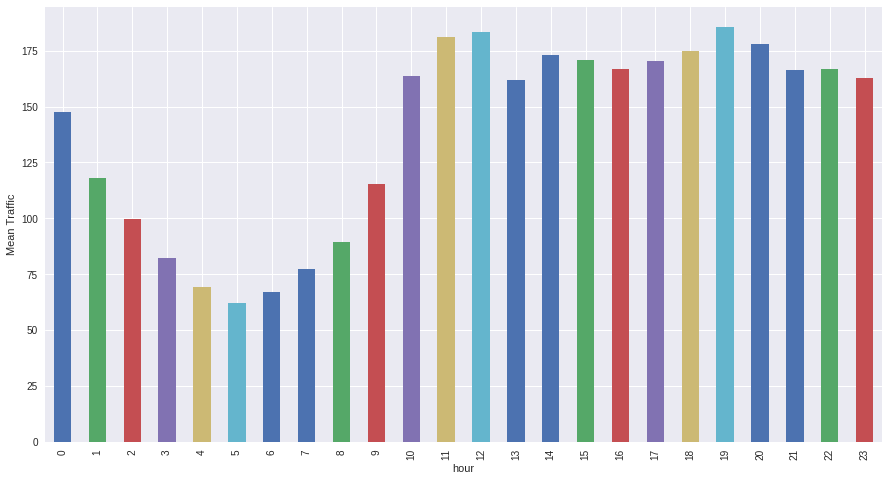

In [6]:
train.groupby('hour')['Count'].mean().plot(kind='bar')
plt.ylabel('Mean Traffic')
plt.show()


#### Traffic decreases after 12 am till 5 am.


### DAY OF WEEK

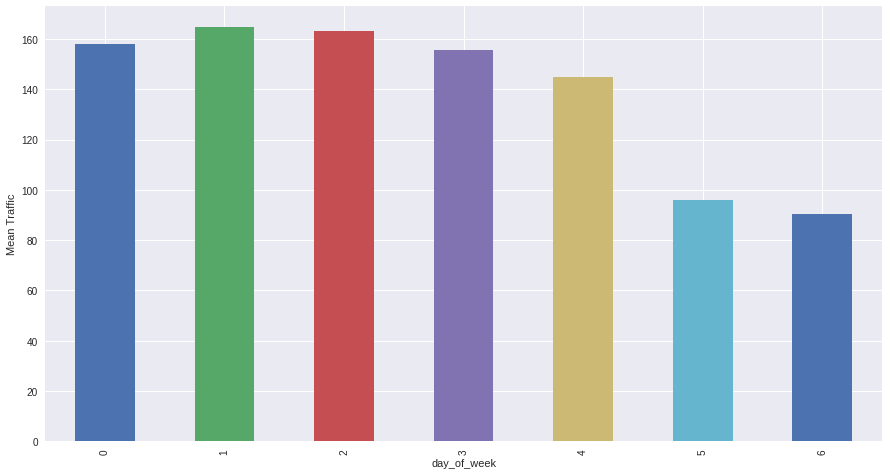

In [7]:
train.groupby('day_of_week')['Count'].mean().plot(kind='bar')
plt.ylabel('Mean Traffic')
plt.show()

#### There are some seasonal properties. Traffic may be low on week ends.

### DAY OF MONTH

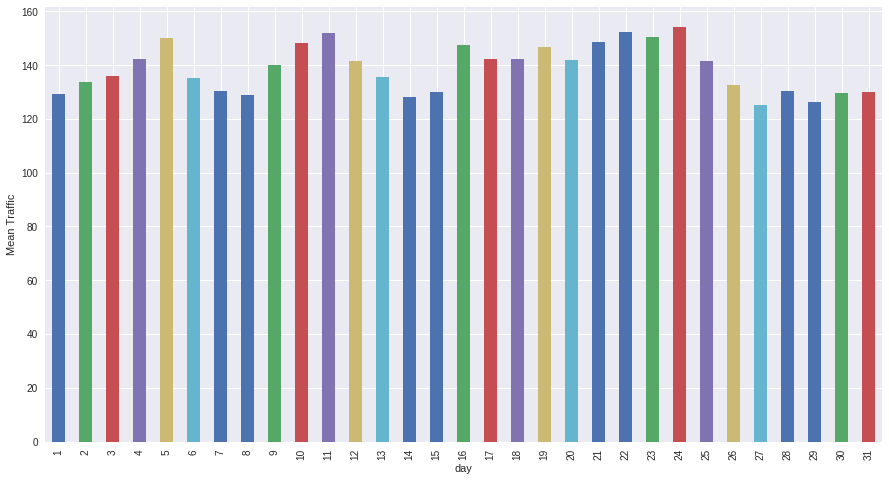

In [8]:
train.groupby('day')['Count'].mean().plot(kind='bar')
plt.ylabel('Mean Traffic')
plt.show()

#### A lot of noise is present.

### Month

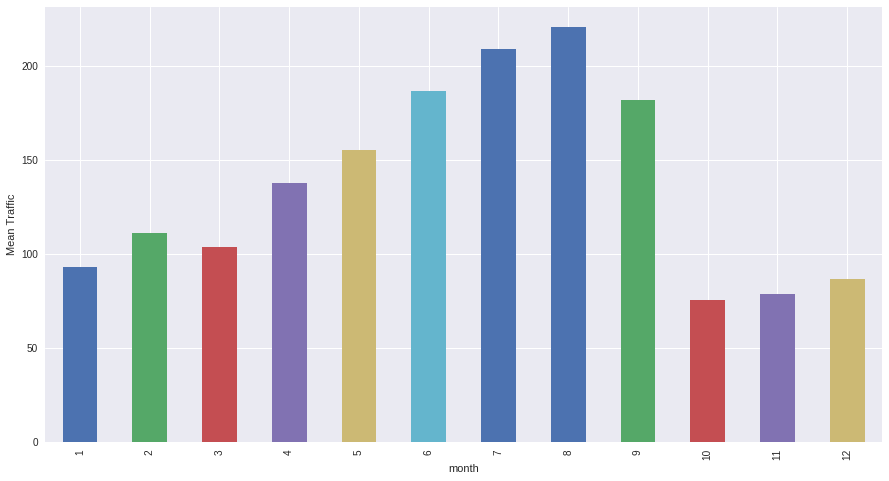

In [9]:
train.groupby('month')['Count'].mean().plot(kind='bar')
plt.ylabel('Mean Traffic')
plt.show()

#### Seasonal properties can be seen here. Traffic is very low in months october, november and december. Traffic increases gradually from april.


### Year

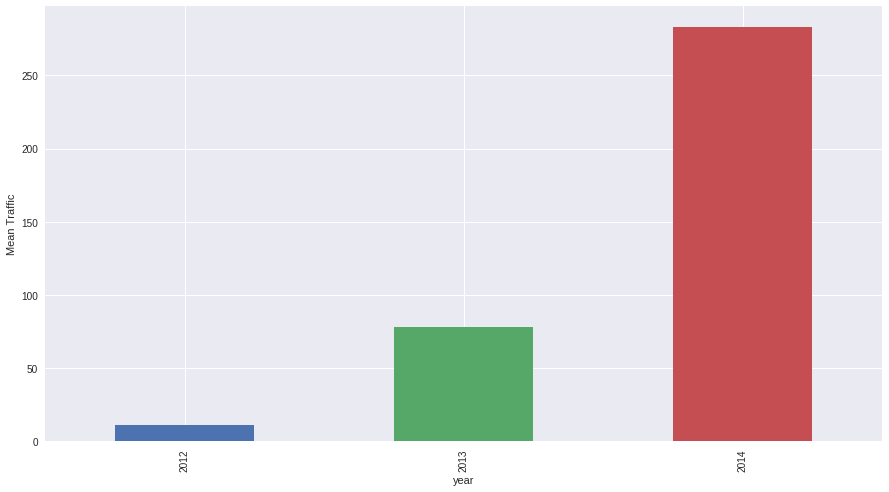

In [10]:
train.groupby('year')['Count'].mean().plot(kind='bar')
plt.ylabel('Mean Traffic')
plt.show()

#### There is an increasing trend. Traffic seems to increase exponentially over the years.

### AGGREGATED SERIES

### Daily

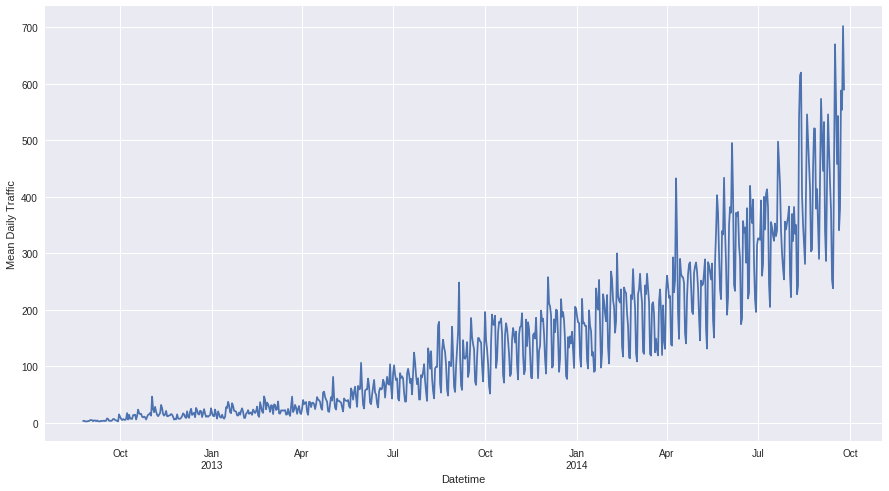

In [11]:
train.Count.resample('D').mean().plot()
plt.ylabel('Mean Daily Traffic')
plt.show()

### Monthly

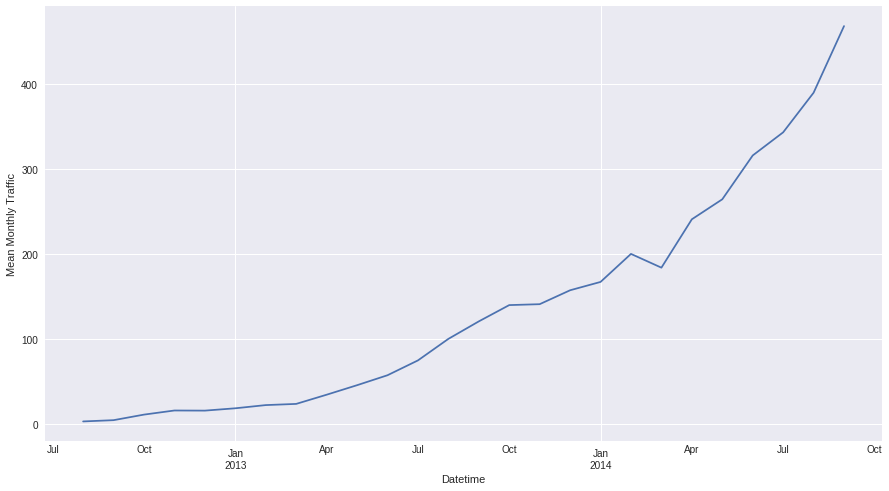

In [12]:
train.Count.resample('M').mean().plot()
plt.ylabel('Mean Monthly Traffic')
plt.show()

### Yearly

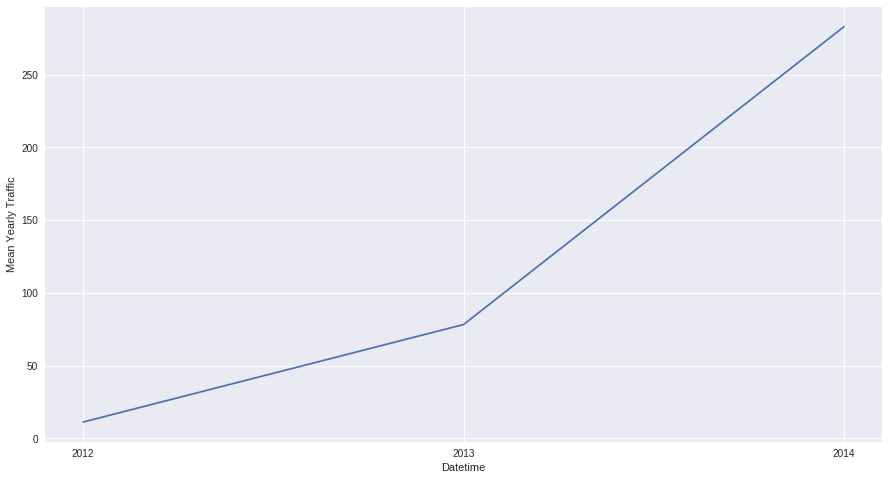

In [13]:
train.Count.resample('Y').mean().plot()
plt.ylabel('Mean Yearly Traffic')
plt.show()

## Inferences

   *  There is an exponentially increasing trend.
   * There might be multiple seasonalities. Weekly and Monthly


## Approach: We will model for day of the week instead of hour.

## Create New DataFrame for Prophet (Daily)

In [14]:
trainDay = np.log(train.Count.resample('D').sum()).to_frame(name='Count')
#trainDay = (trainDay - trainDay.shift(1)).to_frame(name='Count')
trainDay['y'] = trainDay.Count
trainDay['ds'] = trainDay.index
trainDay.drop('Count', inplace=True, axis=1)
trainDay.head()

,y,ds
Datetime,,
2012-08-25,4.330733,2012-08-25
2012-08-26,4.477337,2012-08-26
2012-08-27,4.127134,2012-08-27
2012-08-28,4.060443,2012-08-28
2012-08-29,4.094345,2012-08-29


## Create Model and Forecast

In [18]:
from fbprophet import Prophet

m = Prophet(weekly_seasonality=True, yearly_seasonality=True)
m.fit(trainDay)
future = m.make_future_dataframe(periods=213)
forecast = m.predict(future)

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/usr/local/lib/python3.6/dist-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


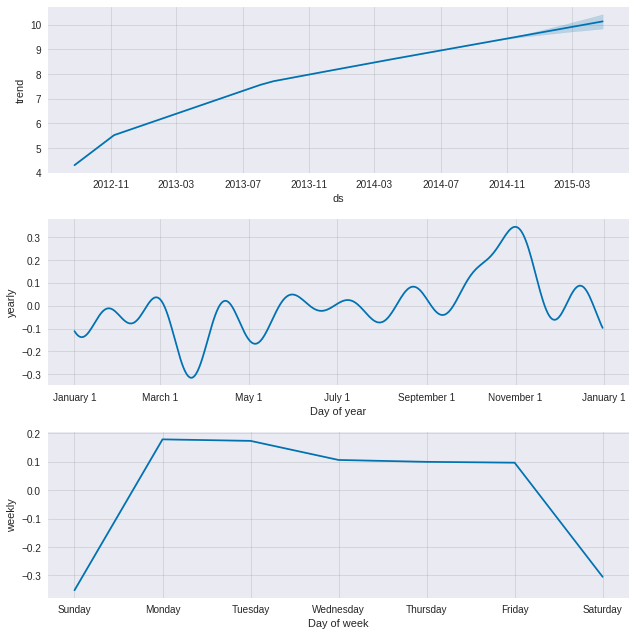

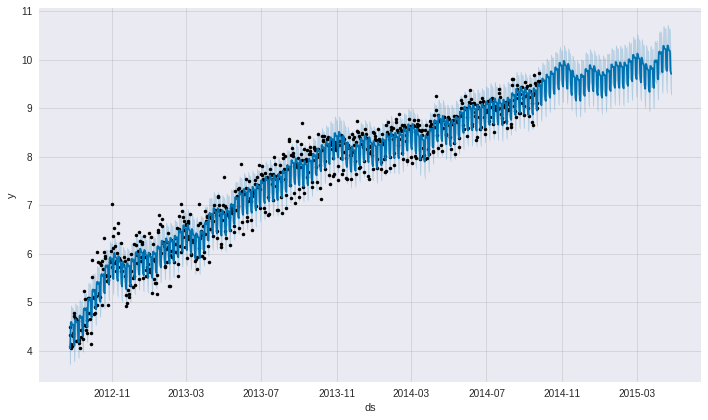

In [19]:
_ = m.plot_components(forecast)
_ = m.plot(forecast)

## Convert to hourly and save to a csv file

In [20]:
forecast.set_index(forecast.ds, inplace=True)
forecast['year'] = forecast.index.year
forecast['month'] = forecast.index.month
forecast['day'] = forecast.index.day

forecast.head()

,ds,trend,trend_lower,trend_upper,yhat_lower,yhat_upper,seasonal,seasonal_lower,seasonal_upper,seasonalities,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,yhat,year,month,day
ds,,,,,,,,,,,,,,,,,,,,,
2012-08-25,2012-08-25,4.306698,4.306698,4.306698,3.745185,4.377325,-0.226571,-0.226571,-0.226571,-0.226571,...,-0.304819,-0.304819,-0.304819,0.078248,0.078248,0.078248,4.080126,2012,8,25
2012-08-26,2012-08-26,4.323458,4.323458,4.323458,3.707613,4.360283,-0.278563,-0.278563,-0.278563,-0.278563,...,-0.352099,-0.352099,-0.352099,0.073536,0.073536,0.073536,4.044895,2012,8,26
2012-08-27,2012-08-27,4.340218,4.340218,4.340218,4.287276,4.934348,0.246800,0.246800,0.246800,0.246800,...,0.179221,0.179221,0.179221,0.067579,0.067579,0.067579,4.587018,2012,8,27
2012-08-28,2012-08-28,4.356978,4.356978,4.356978,4.267113,4.913292,0.234396,0.234396,0.234396,0.234396,...,0.173877,0.173877,0.173877,0.060519,0.060519,0.060519,4.591374,2012,8,28
2012-08-29,2012-08-29,4.373738,4.373738,4.373738,4.205054,4.890189,0.159188,0.159188,0.159188,0.159188,...,0.106663,0.106663,0.106663,0.052525,0.052525,0.052525,4.532926,2012,8,29


In [21]:
forecast['yhat'] = np.exp(forecast.yhat)
forecast.head()

,ds,trend,trend_lower,trend_upper,yhat_lower,yhat_upper,seasonal,seasonal_lower,seasonal_upper,seasonalities,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,yhat,year,month,day
ds,,,,,,,,,,,,,,,,,,,,,
2012-08-25,2012-08-25,4.306698,4.306698,4.306698,3.745185,4.377325,-0.226571,-0.226571,-0.226571,-0.226571,...,-0.304819,-0.304819,-0.304819,0.078248,0.078248,0.078248,59.152936,2012,8,25
2012-08-26,2012-08-26,4.323458,4.323458,4.323458,3.707613,4.360283,-0.278563,-0.278563,-0.278563,-0.278563,...,-0.352099,-0.352099,-0.352099,0.073536,0.073536,0.073536,57.105172,2012,8,26
2012-08-27,2012-08-27,4.340218,4.340218,4.340218,4.287276,4.934348,0.246800,0.246800,0.246800,0.246800,...,0.179221,0.179221,0.179221,0.067579,0.067579,0.067579,98.201121,2012,8,27
2012-08-28,2012-08-28,4.356978,4.356978,4.356978,4.267113,4.913292,0.234396,0.234396,0.234396,0.234396,...,0.173877,0.173877,0.173877,0.060519,0.060519,0.060519,98.629842,2012,8,28
2012-08-29,2012-08-29,4.373738,4.373738,4.373738,4.205054,4.890189,0.159188,0.159188,0.159188,0.159188,...,0.106663,0.106663,0.106663,0.052525,0.052525,0.052525,93.030366,2012,8,29


In [22]:
merge = test.merge(forecast, on=['year', 'month', 'day'], how='left', copy=True)
temp = train.groupby('hour')['Count'].sum() / train.Count.sum()
merge['ratio'] = merge.hour.map(temp)
#merge['yhat'] = 10**(merge.yhat)
merge['Count'] = merge.yhat * merge.ratio
merge.head()

,ID,year,month,day,day_of_week,hour,ds,trend,trend_lower,trend_upper,...,seasonalities_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,yhat,ratio,Count
0,18288,2014,9,26,4,0,2014-09-26,9.303388,9.303388,9.303388,...,0.174845,0.09715,0.09715,0.09715,0.077695,0.077695,0.077695,13072.076731,0.044287,578.917675
1,18289,2014,9,26,4,1,2014-09-26,9.303388,9.303388,9.303388,...,0.174845,0.09715,0.09715,0.09715,0.077695,0.077695,0.077695,13072.076731,0.035343,462.006592
2,18290,2014,9,26,4,2,2014-09-26,9.303388,9.303388,9.303388,...,0.174845,0.09715,0.09715,0.09715,0.077695,0.077695,0.077695,13072.076731,0.029911,390.999878
3,18291,2014,9,26,4,3,2014-09-26,9.303388,9.303388,9.303388,...,0.174845,0.09715,0.09715,0.09715,0.077695,0.077695,0.077695,13072.076731,0.024714,323.069231
4,18292,2014,9,26,4,4,2014-09-26,9.303388,9.303388,9.303388,...,0.174845,0.09715,0.09715,0.09715,0.077695,0.077695,0.077695,13072.076731,0.020802,271.928348


In [0]:
TSProphet = merge[['ID', 'Count']]
TSProphet.to_csv('TSProphet.csv')

In [0]:
from google.colab import files

files.download('TSProphet.csv')

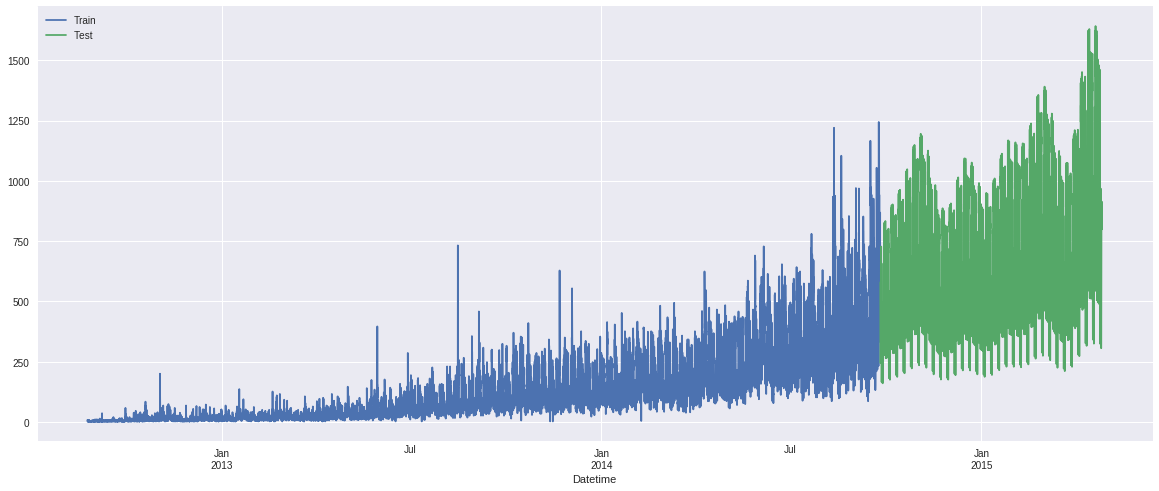

In [24]:
plt.figure(figsize=(20,8))
train.Count.plot(label='Train')
pd.Series(data=merge.Count.values, index = test.index).plot(label='Test')
plt.legend(loc='best')
plt.show()